In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from keras.models import Sequential
from keras.layers import *
from keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split, GridSearchCV
import tensorflow as tf
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

sns.set_theme(rc={'figure.figsize':(16,8)})

def plot_confusion_matrix(Y_test, predicted):
    predicted = tf.squeeze(predicted)
    predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
    actual = np.array(Y_test)
    conf_mat = confusion_matrix(actual, predicted)
    displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    displ.plot()


def my_read_data():
    # Reads already cleaned and imputed data from .csv

    file_path_train = Path('adults_data','adults_imputed_train_data.csv')
    file_path_test = Path('adults_data','adults_imputed_test_data.csv')

    df_train = pd.read_csv(file_path_train)
    df_test = pd.read_csv(file_path_test)

    X_train = df_train.iloc[:,:-1]
    X_test = df_test.iloc[:,:-1]
    X_train = pd.get_dummies(X_train, dtype=float)
    X_test = pd.get_dummies(X_test, dtype=float)
    
    Y_train = df_train.iloc[:,-1]
    Y_test = df_test.iloc[:,-1]

    Y_train = Y_train.replace("<=50K", 0)
    Y_train = Y_train.replace(">50K", 1)
    Y_test = Y_test.replace("<=50K", 0)
    Y_test = Y_test.replace(">50K", 1)

    return X_train, X_test, Y_train, Y_test


def balance_data(X_train, Y_train, type="ros"):

    if type == "ros":
        ros = RandomOverSampler(random_state=5)
        X_train, Y_train = ros.fit_resample(X_train, Y_train)
    elif type == "smote":
        smote = SMOTE(random_state=5, k_neighbors=5)
        X_train, Y_train = smote.fit_resample(X_train, Y_train)
    else:
        print("Balancing type not found")

    return X_train, Y_train

* scaling
* train test split
* oversampling

In [10]:
def classification_nn(epochs=200, batch_size=20, balance_type=None):

    X_train, X_test, Y_train, Y_test = my_read_data()

    if balance_type != None: 
        X_train, Y_train = balance_data(X_train, Y_train, type=balance_type)

    # Build
    model = Sequential()
    model.add(Dense(250, "relu", input_shape=(66,)))
    model.add(Dense(125, "relu"))
    model.add(Dense(60, "relu"))
    model.add(Dense(1, 'sigmoid'))

    # Compile 
    model.compile(loss="binary_crossentropy", metrics=[tf.keras.metrics.Recall()], optimizer=Adam(learning_rate=0.001))
    model.summary()

    # Fit & Predict
    model_fit = model.fit(X_train, Y_train, validation_split=0.15, batch_size=batch_size, epochs=epochs, verbose=True)    
    predictions_rnn = model.predict(X_test)

    # tresholding
    predictions_rnn = np.where(predictions_rnn >= 0.5, 1, 0)

    # Get accuracy
    #train_accuracy = model_fit.history['accuracy']
    #val_accuracy = model_fit.history['val_accuracy']


    # Plot accuracy
    #epochs = range(1, len(train_accuracy) + 1)
    #plt.ylim(0,1)
    #plt.plot(epochs, train_accuracy, label="Training set")
    #plt.plot(epochs, val_accuracy, label="Validation set")
    # plt.title('Training and Validation Accuracy')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.show()

    print("Accuracy: ", accuracy_score(Y_test, predictions_rnn))
    print("F1 Score: ", f1_score(Y_test, predictions_rnn))
    print("\nClassification Report:")
    print(classification_report(Y_test, predictions_rnn))

    cm = ConfusionMatrixDisplay.from_predictions(Y_test, predictions_rnn) 
    cm.ax_.set_title("Confusion matrix for Neural Network Classification")
    plt.show()

In [3]:
def classification_lr(balance_type=None):
    
    X_train, X_test, Y_train, Y_test = my_read_data()

    if balance_type != None: 
        X_train, Y_train = balance_data(X_train, Y_train, type=balance_type)

    model_lr = LogisticRegression(max_iter=1000).fit(X_train, Y_train)
    predictions_lr = model_lr.predict(X_test)
    
    
    print("Accuracy: ", accuracy_score(Y_test, predictions_lr))
    print("F1 Score: ", f1_score(Y_test, predictions_lr))
    print("\nClassification Report:")
    print(classification_report(Y_test, predictions_lr))

    cm = ConfusionMatrixDisplay.from_estimator(model_lr, X_test, Y_test) 
    cm.ax_.set_title("Confusion matrix for Logistic Regression Classification")
    plt.show()

In [8]:
def classification_xgb(balance_type=None, grid=False):

    X_train, X_test, Y_train, Y_test = my_read_data()

    if balance_type != None: 
        X_train, Y_train = balance_data(X_train, Y_train, type=balance_type)

    model_xgb = XGBClassifier()

    if grid:

        param_grid = {'gamma': [0.08],
              'learning_rate': [0.6],
              'max_depth': [150],
              'n_estimators': [1100],
              'reg_alpha': [0.5],
              'reg_lambda': [0.5]}
        
        # Define & fit grid search
        grid_search = GridSearchCV(model_xgb, param_grid, cv=5, scoring='f1')
        grid_search.fit(X_train, Y_train)

        print("Best Hyperparameters:", grid_search.best_params_)
        print("Best F1 score:", grid_search.best_score_)

        # Create the best model
        model_xgb = XGBClassifier(gamma=grid_search.best_params_['gamma'], 
                                  learning_rate=grid_search.best_params_['learning_rate'],
                                  n_estimators=grid_search.best_params_['n_estimators'],
                                  reg_alpha=grid_search.best_params_['reg_alpha'],
                                  reg_lambda=grid_search.best_params_['reg_lambda'])

    # fit & predict
    model_xgb.fit(X_train, Y_train)
    predictions_xgb = model_xgb.predict(X_test)


    print("Accuracy:", accuracy_score(Y_test, predictions_xgb))
    print("F1 Score: ", f1_score(Y_test, predictions_xgb))
    print("\nClassification Report:")
    print(classification_report(Y_test, predictions_xgb))

    cm_im = ConfusionMatrixDisplay.from_estimator(model_xgb, X_test, Y_test) 
    cm_im.ax_.set_title("Confusion matrix for XGBoost Classification")
    plt.show()

In [14]:
def classification_knn(balance_type=None, grid=False):

    X_train, X_test, Y_train, Y_test = my_read_data()

    if balance_type != None: 
        X_train, Y_train = balance_data(X_train, Y_train, type=balance_type)

    model_knn = KNeighborsClassifier()


    if grid:
        
        param_grid = {'n_neighbors': [11],
              'weights': ['distance'],
              'algorithm': ['auto'],
              'p': [1]}
        
        # Define & fit grid search
        grid_search = GridSearchCV(model_knn, param_grid, cv=5, scoring='f1')
        grid_search.fit(X_train, Y_train)

        print("Best Hyperparameters:", grid_search.best_params_)
        print("Best F1 score:", grid_search.best_score_)

        # Define best model
        model_knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'],
                                    weights=grid_search.best_params_['weights'],
                                    algorithm=grid_search.best_params_['algorithm'],
                                    p=grid_search.best_params_['p'])

    # fit & predict
    model_knn.fit(X_train, Y_train)
    print(model_knn.get_params())
    predictions_knn = model_knn.predict(X_test)


    print("Accuracy:", accuracy_score(Y_test, predictions_knn))
    print("F1 Score: ", f1_score(Y_test, predictions_knn))
    print("\nClassification Report:")
    print(classification_report(Y_test, predictions_knn))

    cm_im = ConfusionMatrixDisplay.from_estimator(model_knn, X_test, Y_test) 
    cm_im.ax_.set_title("Confusion matrix for KNN Classification")
    plt.show()

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Best F1 score: 0.8810357806739418
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Accuracy: 0.9146667245835415
F1 Score:  0.8358059258640145

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     34621
           1       0.80      0.88      0.84     11422

    accuracy                           0.91     46043
   macro avg       0.88      0.90      0.89     46043
weighted avg       0.92      0.91      0.92     46043



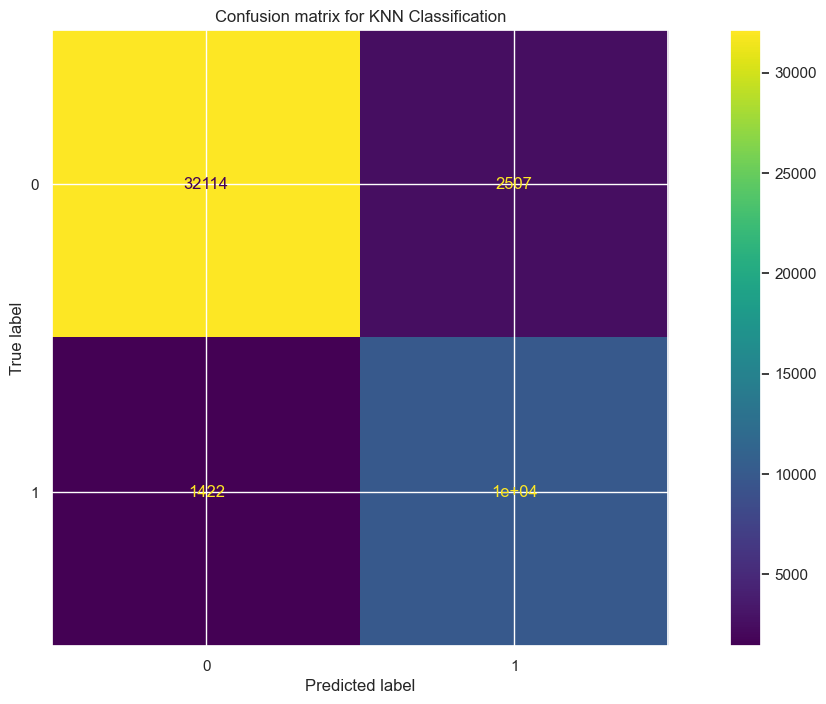

In [15]:
classification_knn(balance_type="ros", grid=True)

Best Hyperparameters: {'gamma': 0.08, 'learning_rate': 0.6, 'max_depth': 150, 'n_estimators': 1100, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
Best F1 score: 0.9033540283020113
Accuracy: 0.8916664856764329
F1 Score:  0.8081243268195107

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     34621
           1       0.72      0.92      0.81     11422

    accuracy                           0.89     46043
   macro avg       0.85      0.90      0.87     46043
weighted avg       0.91      0.89      0.90     46043



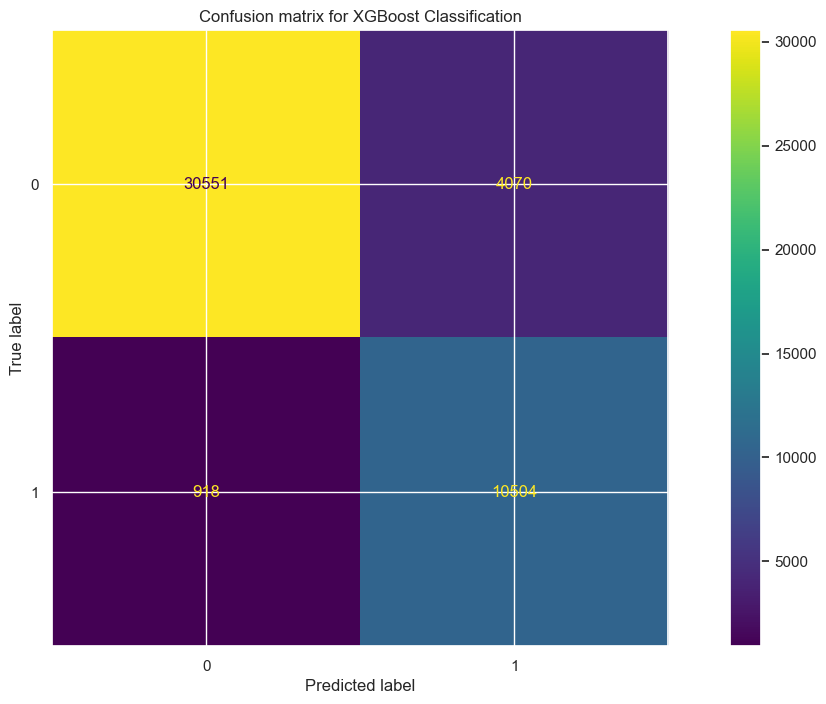

In [9]:
classification_xgb(balance_type="ros", grid=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 250)               16750     
                                                                 
 dense_1 (Dense)             (None, 125)               31375     
                                                                 
 dense_2 (Dense)             (None, 60)                7560      
                                                                 
 dense_3 (Dense)             (None, 1)                 61        
                                                                 
Total params: 55746 (217.76 KB)
Trainable params: 55746 (217.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200

2355/2355 [==============================] - 4s 1ms/step - loss: 1.8630 - recall: 0.7462 - val_loss: 0.6572 - val_recall: 0.6445
Epoch 2

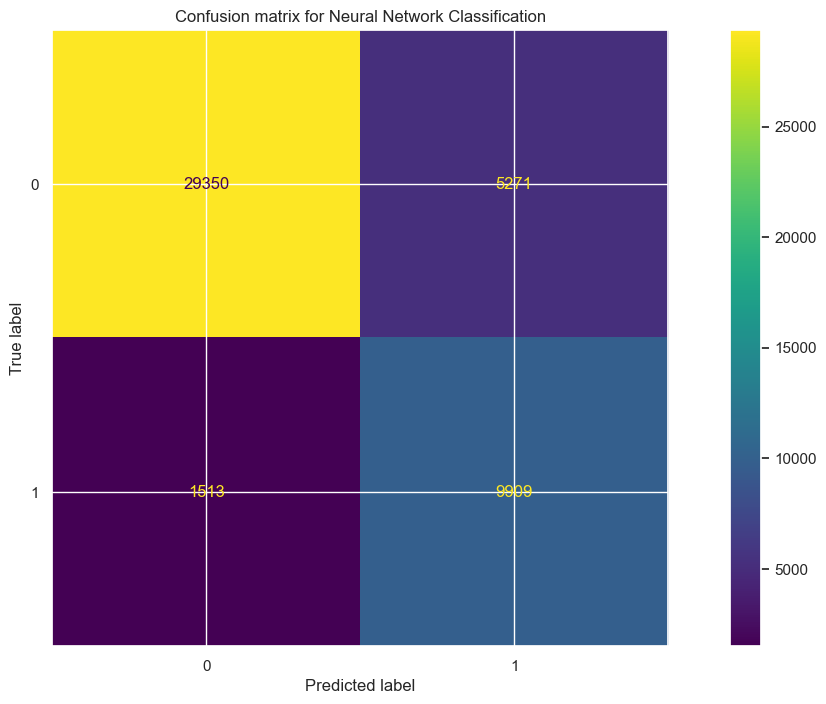

In [12]:
classification_nn(balance_type="ros")